# Проект "Что-то про фильмы"
В ролях: Никонова Анна, Добрынина Анастасия

Режиссер-постановщик: Наша поехавшая кукуха


### Пролог. Начало

> Изначальный план был прост: использовать АРI Кинопоиска

>К сожалению, эти планы были не сбыточны по нескольким причинам:

>Первая из них - победить дракона, то есть: разобраться с документацией и сложностью структуры API, нам оказалась не по зубам.

Покажу вам наши последние наработки, когда мы уже почти достигли успеха:

In [1]:
import pandas as pd
import requests
import random


#сделайте вид, что тут нет токена, я дала эту ссылку только вам и приду за вами, если что!

headers = {"X-API-KEY": "KKATCJP-SWJMQS1-QT3FD0Y-45SWC8M"}

def get_random_movie(year_range):
    response = requests.get(
        'https://api.kinopoisk.dev/v1.4/movie',
        params={
            "limit": 10,
            "page": 1,
            "year": year_range
        },
        headers=headers
    )
    movies = response.json()
    return movies["docs"]

# year_range = "2023"
year_range = "1970-2023"

# genres = ["боевик", "драма"]
# или чтобы исключить жанр
# genres = ["!боевик"]
movie = get_random_movie(year_range)
df = pd.DataFrame(movie)
print(df)

        id                         name  \
0  5611838                      Райзмен   
1  5632634                   Технологии   
2  5618636               Русский Медичи   
3  5618635             Русская живопись   
4  5618634  Русская классическая музыка   
5  5618630                Русский театр   
6  5613575             Цветняшки. Песни   
7  5608205                    Дихотомии   
8  5608206       Арена ди Верона: Тоска   
9  5613545       Лучший джасс – русский   

                            alternativeName             type  typeNumber  \
0                                   RiseMan  animated-series           5   
1                           The Tech Effect        tv-series           2   
2                                      None            movie           1   
3                                      None            movie           1   
4                                      None            movie           1   
5                                      None            movie          

>Вы скажете, да ладно! Все же работает! Но тут оказалось, что у дракона не одна голова, а три!!!

> И вторая: количество запросов в день ограничено))) Дада, к сожалению, лимит не позволяет скачать такое количество данных, чтобы мы отсеяли всю мишуру и получили около 1000 нормальных примеров.

>Тут мы решили рубить третью голову: Например, отсеять всю мишуру заранее и обращаться только за определенными фильмами. Это, как мы думали, можно сделать, если следовать их документации: https://api.kinopoisk.dev/documentation#/


>А вот тут нас в нокаут вынесла сложность их документация и фильтров. Мы не смогли с ними разобраться. Смогли воспользоваться только их фильтрами, получить вот такой url: https://api.kinopoisk.dev/v1.4/movie?page=1&limit=10&selectFields=id&selectFields=name&selectFields=type&selectFields=year&selectFields=rating&selectFields=budget&selectFields=audience&selectFields=movieLength&selectFields=genres&selectFields=countries&selectFields=persons&selectFields=fees&notNullFields=name&notNullFields=type&notNullFields=year&notNullFields=budget.value&notNullFields=budget.currency&notNullFields=audience.count&notNullFields=audience.country&notNullFields=movieLength&notNullFields=genres.name&notNullFields=countries.name&notNullFields=persons.id&notNullFields=persons.name&notNullFields=persons.profession&notNullFields=fees.world.value&type=movie&status=completed

>Дальше, к сожалению, ничего не сработало. Мы даже вступили в чатик девелоперов этого АПИ!!! И не смогли найти ответы на свои вопросы((

### Это было грустное вступление, чтобы вы поняли, что мы просто отчаялись, а не просто не захотели попробовать.

Теперь к основному повествованию:

Итак, отчаявшись в Кинопоиске, но не отчаявшись в своем проекте, мы решили не менять тему и нашли датасет на Kagle:

https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download&select=credits.csv

Датасет нам понравился, мы в нем поковырялись и решили его использовать!

##### первым делом - берем нужные нам столбцы, формируем датасет и убираем лишнюю мишуру:

In [2]:
import pandas as pd
import json
import requests
import itertools
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
import numpy as np


#Почему гугл диск? Потому что файл слишком большой, гит не дает его загрузить(
url = 'https://drive.google.com/uc?export=download&id=1P0JCqEI8XHMhUavVWJ_uvIQDJ6OuBp1X'


response = requests.get(url)

with open('data.csv', 'wb') as file:
    file.write(response.content)

data1 = pd.read_csv('data.csv')

data1['genres'] = data1['genres'].apply(lambda x: ', '.join([genre['name'] for genre in eval(x)]))

df_1 = data1[['id','title', 'budget', 'revenue', 'release_date', 'genres', 'runtime','vote_average']]
#Тут мы убираем лишнее и смотрим, достаточно ли данных осталось:
df_1=df_1[df_1['vote_average']>0] 
filtered_df = df_1.loc[(df_1['budget'] != '0') & (df_1['revenue'] != 0)]
filtered_df['budget'] = filtered_df['budget'].astype(int)
filtered_df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id,title,budget,revenue,release_date,genres,runtime,vote_average
0,862,Toy Story,30000000,373554033.0,1995-10-30,"Animation, Comedy, Family",81.0,7.7
1,8844,Jumanji,65000000,262797249.0,1995-12-15,"Adventure, Fantasy, Family",104.0,6.9
3,31357,Waiting to Exhale,16000000,81452156.0,1995-12-22,"Comedy, Drama, Romance",127.0,6.1
5,949,Heat,60000000,187436818.0,1995-12-15,"Action, Crime, Drama, Thriller",170.0,7.7
8,9091,Sudden Death,35000000,64350171.0,1995-12-22,"Action, Adventure, Thriller",106.0,5.5
...,...,...,...,...,...,...,...,...
45250,24049,Sivaji: The Boss,12000000,19000000.0,2007-06-14,"Action, Comedy, Drama",185.0,6.9
45399,280422,All at Once,750000,3.0,2014-06-05,"Crime, Comedy",0.0,6.0
45409,62757,Savages,800000,1328612.0,2006-11-23,"Comedy, Drama",100.0,5.8
45412,63281,Pro Lyuboff,2000000,1268793.0,2010-09-30,"Romance, Drama",107.0,4.0


Количество - 5 тыс., нам подходит. 

**Добавляем новый признак**

Решили посмотреть не только доходы и бюджет, но и профит! Мы же экономисты!!!

In [3]:
filtered_df['profit'] = filtered_df['revenue'] - filtered_df['budget']
filtered_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,title,budget,revenue,release_date,genres,runtime,vote_average,profit
0,862,Toy Story,30000000,373554033.0,1995-10-30,"Animation, Comedy, Family",81.0,7.7,343554033.0
1,8844,Jumanji,65000000,262797249.0,1995-12-15,"Adventure, Fantasy, Family",104.0,6.9,197797249.0
3,31357,Waiting to Exhale,16000000,81452156.0,1995-12-22,"Comedy, Drama, Romance",127.0,6.1,65452156.0
5,949,Heat,60000000,187436818.0,1995-12-15,"Action, Crime, Drama, Thriller",170.0,7.7,127436818.0
8,9091,Sudden Death,35000000,64350171.0,1995-12-22,"Action, Adventure, Thriller",106.0,5.5,29350171.0
...,...,...,...,...,...,...,...,...,...
45250,24049,Sivaji: The Boss,12000000,19000000.0,2007-06-14,"Action, Comedy, Drama",185.0,6.9,7000000.0
45399,280422,All at Once,750000,3.0,2014-06-05,"Crime, Comedy",0.0,6.0,-749997.0
45409,62757,Savages,800000,1328612.0,2006-11-23,"Comedy, Drama",100.0,5.8,528612.0
45412,63281,Pro Lyuboff,2000000,1268793.0,2010-09-30,"Romance, Drama",107.0,4.0,-731207.0


День релиза мало о чем говорит. А вот год нам нужен!

In [4]:
filtered_df['release_date'] = pd.to_datetime(filtered_df['release_date'])
filtered_df['year'] = filtered_df['release_date'].dt.year
filtered_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,title,budget,revenue,release_date,genres,runtime,vote_average,profit,year
0,862,Toy Story,30000000,373554033.0,1995-10-30,"Animation, Comedy, Family",81.0,7.7,343554033.0,1995
1,8844,Jumanji,65000000,262797249.0,1995-12-15,"Adventure, Fantasy, Family",104.0,6.9,197797249.0,1995
3,31357,Waiting to Exhale,16000000,81452156.0,1995-12-22,"Comedy, Drama, Romance",127.0,6.1,65452156.0,1995
5,949,Heat,60000000,187436818.0,1995-12-15,"Action, Crime, Drama, Thriller",170.0,7.7,127436818.0,1995
8,9091,Sudden Death,35000000,64350171.0,1995-12-22,"Action, Adventure, Thriller",106.0,5.5,29350171.0,1995
...,...,...,...,...,...,...,...,...,...,...
45250,24049,Sivaji: The Boss,12000000,19000000.0,2007-06-14,"Action, Comedy, Drama",185.0,6.9,7000000.0,2007
45399,280422,All at Once,750000,3.0,2014-06-05,"Crime, Comedy",0.0,6.0,-749997.0,2014
45409,62757,Savages,800000,1328612.0,2006-11-23,"Comedy, Drama",100.0,5.8,528612.0,2006
45412,63281,Pro Lyuboff,2000000,1268793.0,2010-09-30,"Romance, Drama",107.0,4.0,-731207.0,2010


Посмотрим на типы данных и частично изменим, чтобы было удобно работать с ними:

In [5]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5374 entries, 0 to 45422
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            5374 non-null   object        
 1   title         5374 non-null   object        
 2   budget        5374 non-null   int64         
 3   revenue       5374 non-null   float64       
 4   release_date  5374 non-null   datetime64[ns]
 5   genres        5374 non-null   object        
 6   runtime       5373 non-null   float64       
 7   vote_average  5374 non-null   float64       
 8   profit        5374 non-null   float64       
 9   year          5374 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 461.8+ KB


In [6]:
filtered_df.budget = filtered_df.budget.astype(float)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Теперь убираем пропуски:

In [7]:
filtered_df.isna().sum()

id              0
title           0
budget          0
revenue         0
release_date    0
genres          0
runtime         1
vote_average    0
profit          0
year            0
dtype: int64

**Заполняем пропуски**

Решили заполнить пропуски по рантайму медианой, тк она меньше реагирует на выбросы в выборке, чем среднее:

In [8]:
filtered_df = filtered_df.fillna(filtered_df.median())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [9]:
filtered_df.isna().sum()

id              0
title           0
budget          0
revenue         0
release_date    0
genres          0
runtime         0
vote_average    0
profit          0
year            0
dtype: int64

Теперь данные чистые!

Давайте выведем данные по всем столбцам:

In [10]:
filtered_df.describe()

,budget,revenue,runtime,vote_average,profit,year
count,5.374000e+03,5.374000e+03,5374.000000,5374.000000,5.374000e+03,5374.000000
mean,3.112579e+07,9.043100e+07,109.812430,6.281020,5.930521e+07,1999.763119
std,4.017839e+07,1.662207e+08,22.042448,0.900524,1.396087e+08,15.922197
min,1.000000e+00,1.000000e+00,0.000000,1.000000,-1.657101e+08,1915.000000
25%,5.136250e+06,7.040481e+06,95.000000,5.700000,-1.462000e+06,1994.000000
50%,1.700000e+07,2.999961e+07,106.000000,6.300000,1.111751e+07,2004.000000
75%,4.000000e+07,1.000000e+08,120.000000,6.900000,6.223293e+07,2011.000000
max,3.800000e+08,2.787965e+09,338.000000,9.100000,2.550965e+09,2017.000000


**Начнем визуализацию:**

Строить графики конкретно по годам - не очень информативно. А вот по десятилетиям - это выход!

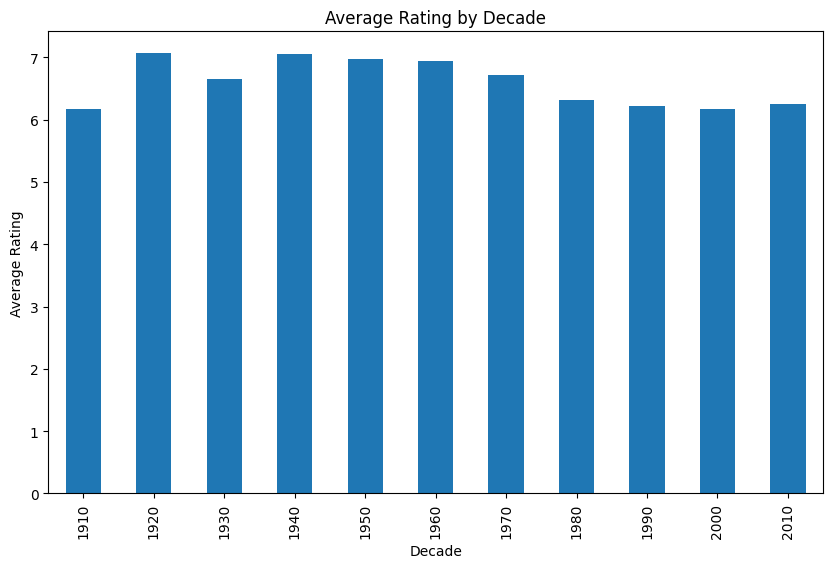

In [11]:

filtered_df['decade'] = (filtered_df['year'] // 10) * 10

# Группируем данные по десятилетиям и считаем средний рейтинг
grouped = filtered_df.groupby('decade')['vote_average'].mean()

# Строим график зависимости среднего рейтинга от десятилетия
grouped.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Decade')
plt.ylabel('Average Rating')
plt.title('Average Rating by Decade')
plt.show()



Что вам сказать - вот в 20х умели снимать фильмы!

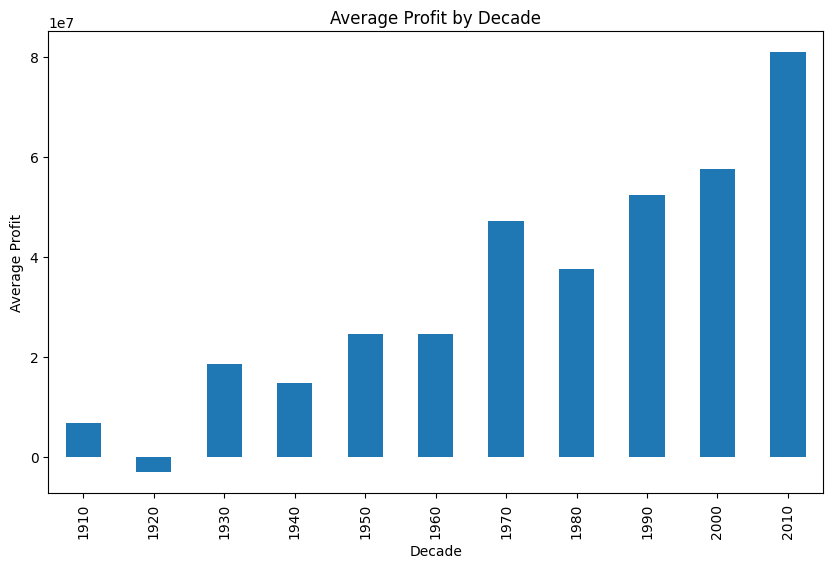

In [12]:
# Группируем данные по десятилетиям и вычисляем средний профит
avg_profit_by_decade = filtered_df.groupby('decade')['profit'].mean()

# Строим график гистограммой зависимости среднего профита от десятилетия
avg_profit_by_decade.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Decade')
plt.ylabel('Average Profit')
plt.title('Average Profit by Decade')
plt.show()

А вот делать деньги на них не умели)

четко видим, что кинематограф учился делать деньги: только со временем это стало прибыльно!

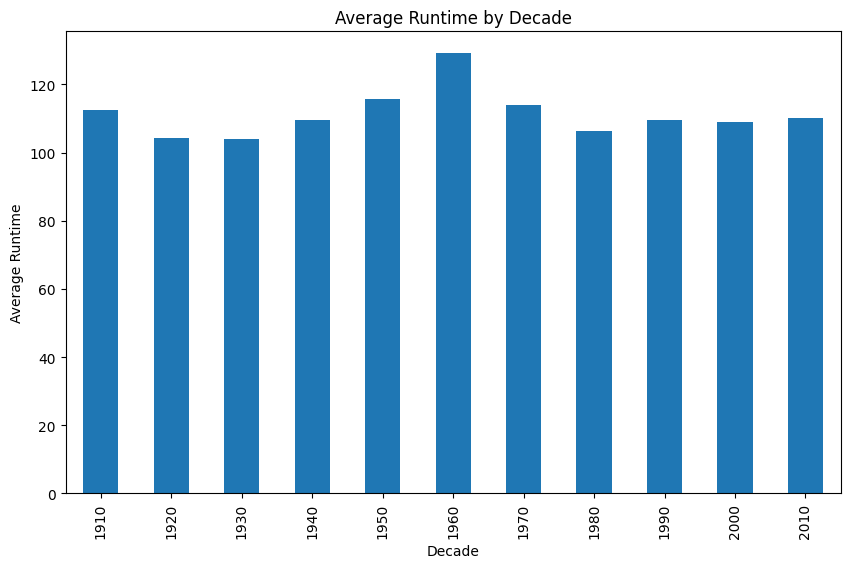

In [13]:
# Группируем данные по десятилетиям и вычисляем средний рантайм
avg_runtime_by_decade = filtered_df.groupby('decade')['runtime'].mean()

# Строим график гистограммой зависимости среднего профита от десятилетия
avg_runtime_by_decade.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Decade')
plt.ylabel('Average Runtime')
plt.title('Average Runtime by Decade')
plt.show()

Эх,ну вот в 60х любили долго, а в последние годы все быстро(

Ну и дальше смотрим все возможные зависимости, чтобы выцепить что-то интересненькое:

Начнем с корреляции - смотрим хитмэп по кор. матрице:

In [14]:
var = ['budget','revenue','runtime','vote_average','profit','year'] #выделили только количественные переменные, с которыми будем работать
cor_mat = filtered_df[var].corr()

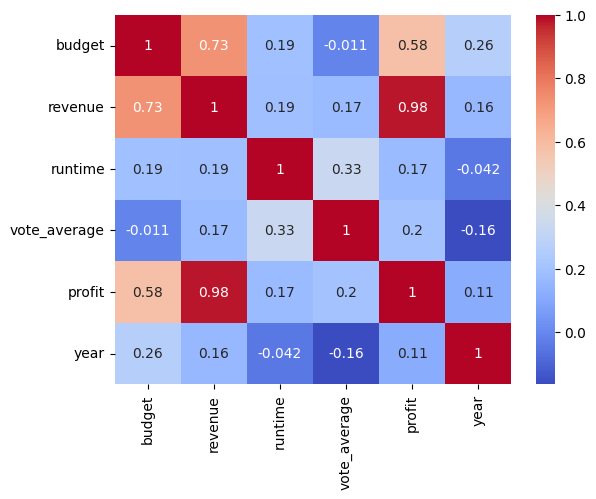

In [15]:
import seaborn as sns
sns.heatmap(cor_mat, annot=True, cmap='coolwarm')
plt.show()

На самом деле никаких ярко выраженных корреляций не наблюдается (конечно, кроме профита, бюджета и выручки, это логично)

Теперь посмотрим гистограммы по всем переменным:

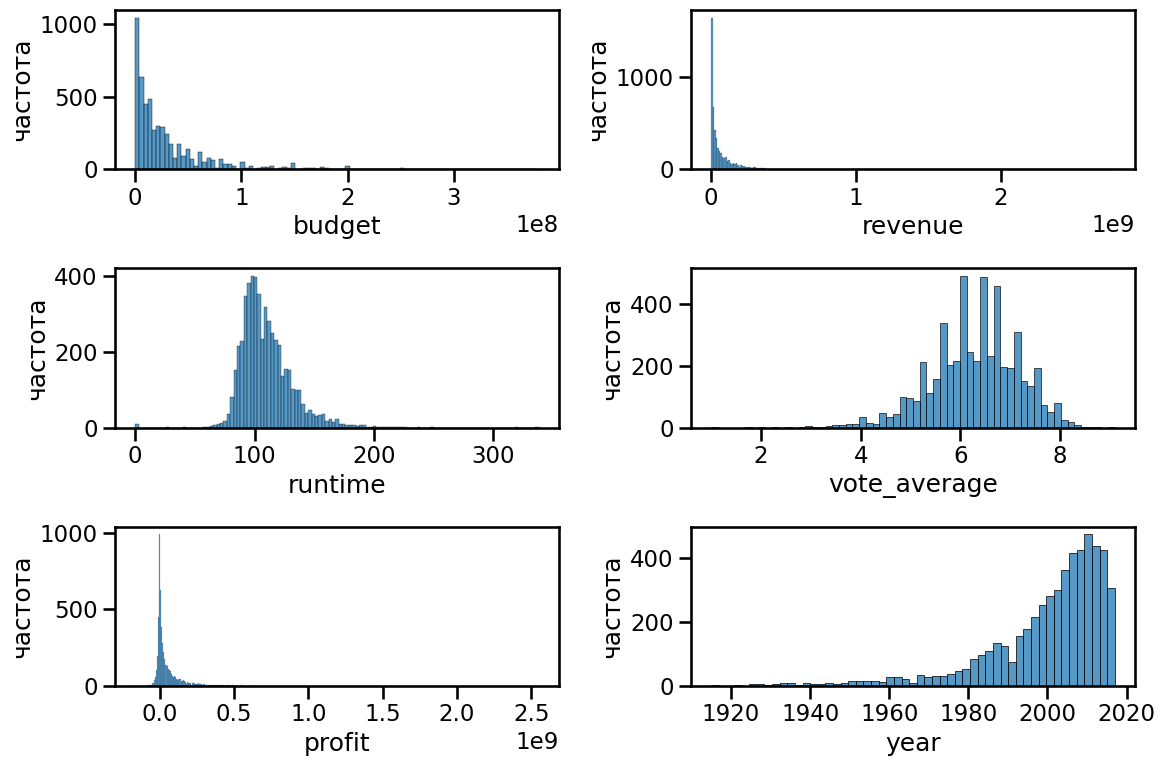

In [16]:
df_graf=filtered_df[var]

# устанавливаем размер графиков
sns.set_context("talk")

# выводим гистограммы для всех переменных из датафрейма
plt.figure(figsize=(12, 8))
for idx, col in enumerate(df_graf.columns):
    plt.subplot(len(df_graf.columns)//2, 2, idx+1)
    sns.histplot(df_graf[col], kde=False)
    plt.xlabel(col)
    plt.ylabel('частота')
plt.tight_layout()
plt.show()

Можем заметить, что по переменным рантайм и войт_эверэйдж получилось что-то похожее на нормальное распределение.  
Однако в ретингах сразу видно, что есть "любимые" значения рейтингов, которые чаще повторяются, чем другие.  
C годами фильмов становится все больше, но - чем больше бюджет, тем меньше фильмов.

**Так как нам дальше интересно говорить именно про прибыль и то, что на нее влияет, мы выводим все диаграммы рассеяния именно с прибылью**

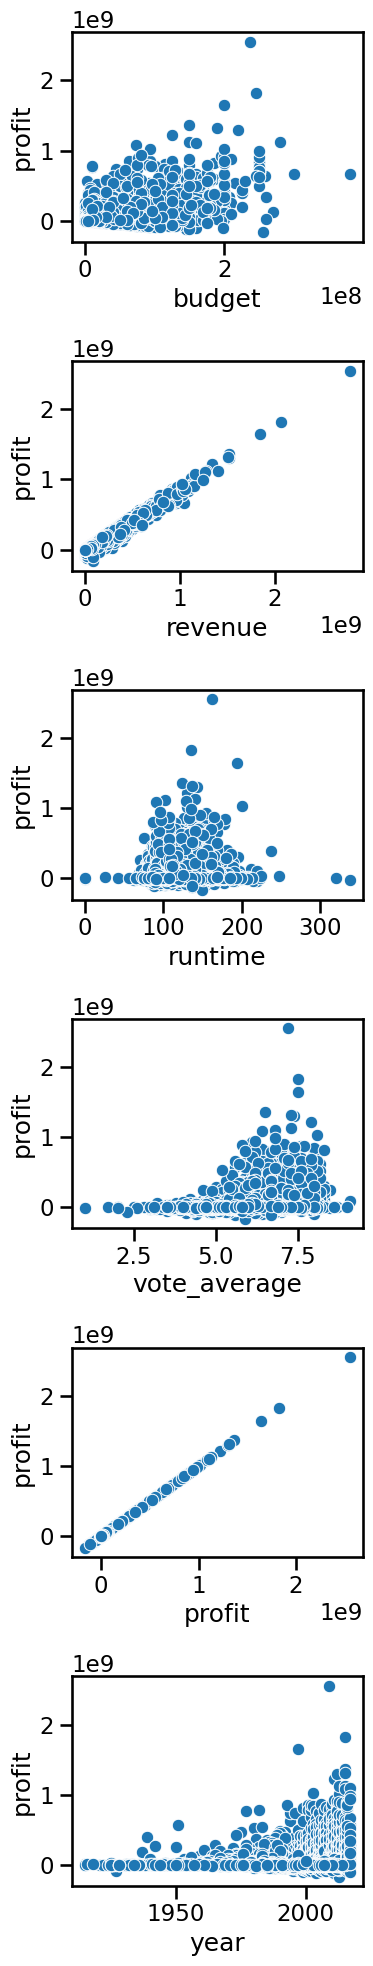

In [17]:
# устанавливаем размер графиков
sns.set_context("talk")

# находим столбец 'profit' в датафрейме
profit_col = df_graf.loc[:, df_graf.columns.str.contains('profit')].squeeze()

# выводим диаграммы рассеяния для всех пар переменных, где по оси y будет столбец 'profit'
plt.figure(figsize=(20, 20))
num_cols = len(df_graf.columns)  # количество всех столбцов, кроме 'profit'

for i in range(num_cols):
        plt.subplot(num_cols, num_cols, i*num_cols + 1)
        sns.scatterplot(x=df_graf.iloc[:, i], y=profit_col, data=df_graf)
        plt.xlabel(df_graf.columns[i])
        plt.ylabel('profit')

plt.tight_layout()
plt.show()

Чтож, идеальная линейная зависимость профита от ревенью это конечно, замечательно. Но, наверно, не то, что нас интересовало)

**Проверяем гипотезу о том, что прибыль от съемок напрямую зависит от рейтинга фильма:**

In [18]:
# уровень значимости
alpha = 0.05

# проводим т-тест
t_stat, p_value = stats.ttest_rel(df_graf['profit'], df_graf['vote_average'])
print(p_value)

# выводим результаты теста
if p_value < alpha:
    print("Отвергаем нулевую гипотезу на уровне значимости 5%")

7.138898565629113e-196
Отвергаем нулевую гипотезу на уровне значимости 5%


Гипотеза отвергается. Прибыль не зависит от рейтинга! (И наша в том числе)

**Проверяем гипотезу о том, что прибыль от съемок напрямую зависит от бюджета, который на него потрачен:**

In [19]:
# уровень значимости
alpha = 0.05

# проводим т-тест
t_stat, p_value = stats.ttest_rel(df_graf['profit'], df_graf['budget'])
print(p_value)

# выводим результаты теста
if p_value < alpha:
    print("Отвергаем нулевую гипотезу на уровне значимости 5%")

6.239116888959905e-64
Отвергаем нулевую гипотезу на уровне значимости 5%


Ни одна из наших гипотез не подтвердилась. Плачем...

Ну чтож. Конечно, пока все против нас. Но мы должны это сделать!

**Будем предсказывать профит на основе данных о годе, бюджете, времени и рейтинге фильма**

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# разделяем данные на матрицу признаков X и вектор целевой переменной y
X = df_graf[['year', 'budget', 'runtime','vote_average']]
y = df_graf['profit']

# обучаем модель линейной регрессии
model = LinearRegression()
model.fit(X, y)



# предсказываем значения profit
prediction = model.predict(X)

mse=((y-prediction)**2).mean()
mae=np.abs(y-prediction).mean()
print(mse)
print(mae)

1.2031698534160288e+16
61868069.92108081


**К сожалению, наш предсказатель работает плохо. Кажется, на доход от фильма слишком сильно влияет множество других факторов, которые не так просто учесть**

## Анекдот:

**- Блин! - сказал слон, наступив на колобка**